In [128]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
# pltのlabelで日本語を使うために必要なモジュールをインポート
import japanize_matplotlib
from matplotlib import rc
from matplotlib.font_manager import FontProperties
from scipy.stats import norm
from scipy.linalg import expm
from math import factorial


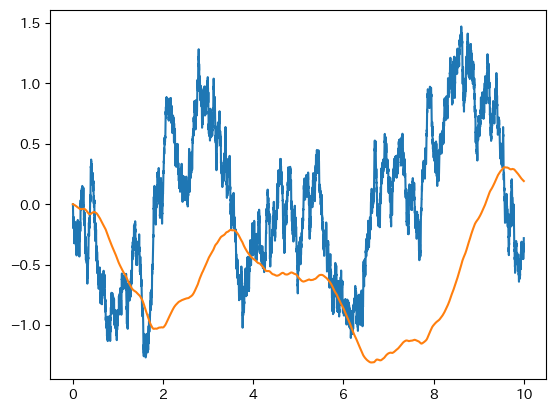

In [185]:
import numpy as np
from scipy.linalg import expm
from scipy.stats import norm

def matrix_exponential(A, t):
    # 固有値と固有ベクトルを計算
    eigenvalues, eigenvectors = np.linalg.eig(A)

    # 固有値の指数行列を作成
    eigenvalues_matrix = np.exp(np.outer(t, eigenvalues))
    # 固有ベクトル行列とその逆行列を計算
    eigenvectors_inv = np.linalg.inv(eigenvectors)
    
    # exp(tA) を計算
    exp_tA = np.einsum('ij,kjl->kil', eigenvectors, eigenvalues_matrix[:, :, np.newaxis] * eigenvectors_inv)
    
    # 実数部分のみを返す
    return np.real(exp_tA)

def linear_Z(theta, t_max, dt, seed):

    np.random.seed(seed)

    theta1 = theta[0]
    theta21 = theta[1]
    theta22 = theta[2]
    theta3 = theta[3]

    A = np.array([[-theta21, -theta22], [theta3, 0]])
    N = int(t_max / dt)  # ステップ数
    times = np.linspace(0, t_max, N + 1)  # 時間グリッド
    
    # ブラウン運動の増分を生成
    dW = norm.rvs(scale=np.sqrt(dt), size=N)
    
    # 全ての時間に対する行列指数関数を計算
    exp_A_t = matrix_exponential(A, times)
    exp_neg_A_t = matrix_exponential(-A, times[:-1])

    # 積分の計算をベクトル化
    theta_vec = np.array([theta1, 0])
    integrand = np.einsum('ijk,k->ij', exp_neg_A_t, theta_vec) * dW[:,np.newaxis]
    cumulative_integral = np.cumsum(integrand, axis=0)
    
    # 形状を合わせるために初めにゼロベクトルを追加
    cumulative_integral = np.vstack((np.zeros((1, A.shape[0])), cumulative_integral))
    
    # Z_t をループなしで計算
    Z_t = np.einsum('ijk,ik->ij', exp_A_t, cumulative_integral)
    
    return Z_t.T

# 使用例
theta = [1,1,1,1]  
t_max = 10.0  # 最大時間の例
dt = 0.001  # タイムステップの例
seed = 0  # ランダムシードの例

Z_t = linear_Z([1,1,1,1], t_max, dt, 2)
# Z_tの形を(N+1, 2)に変更
plt.plot(np.linspace(0, t_max, int(t_max/dt)+1),Z_t[0])
plt.plot(np.linspace(0, t_max, int(t_max/dt)+1),Z_t[1])

In [130]:
def compute_a(theta,k0):
    theta21 = theta[1]
    theta22 = theta[2]
    theta3 = theta[3]
    a0 = 1
    a1 = -theta21
    A0 = np.array([[0,1],[-theta22*theta3,-theta21]])
    An = np.array([np.linalg.matrix_power(A0,n) for n in np.arange(k0+1)])
    x0 = np.array([a0,a1])
    xn = np.einsum('ijk,k->ij',An,x0)
    return xn[:,0]

In [267]:
def compute_s(a,theta, k0):
    theta1 = theta[0]
    theta3 = theta[3]
    
    m = np.arange(k0 + 1)
    k = np.arange(k0 + 1)
    
    m_grid, k_grid = np.meshgrid(m, k, indexing='ij')
    
    l_grid = m_grid - k_grid
    valid_mask = (l_grid >= 0) & (k_grid <= k0)
    
    comb_m_k = scipy.special.comb(m_grid, k_grid) * valid_mask
    comb_m1_k = scipy.special.comb(m_grid + 1, k_grid) * valid_mask
    comb_m2_k1 = scipy.special.comb(m_grid + 2, k_grid + 1) * valid_mask
    
    a_k = a[k_grid] * valid_mask
    a_l = np.where(valid_mask, a[l_grid], 0)
    
    fact_m1 = scipy.special.factorial(m_grid + 1)
    fact_m2 = scipy.special.factorial(m_grid + 2)
    fact_m3 = scipy.special.factorial(m_grid + 3)
    
    mat11 = np.sum(theta1**2 * comb_m_k * (1 / fact_m1) * a_k * a_l, axis=1)
    mat12 = np.sum(theta1**2 * theta3 * comb_m1_k * (1 / fact_m2) * a_k * a_l, axis=1)
    mat22 = np.sum(theta3**2 * theta1**2 * comb_m2_k1 * (1 / fact_m3) * a_k * a_l, axis=1)
    
    s = np.zeros((k0 + 1, 2, 2))
    s[:, 0, 0] = mat11
    s[:, 0, 1] = mat12
    s[:, 1, 0] = mat12
    s[:, 1, 1] = mat22
    
    return s




In [268]:
import numpy as np
import scipy.special

def calculate_d_e(s):
    k0 = np.shape(s)[0] - 1  # k0を変更
    d = np.zeros_like(s)
    e = np.zeros(k0 + 1)
    
    d[0] = np.linalg.inv(s[0])
    
    for k in range(1, k0 + 1):
        p_idx, q_idx ,r_idx= np.meshgrid(np.arange(k), np.arange(k),np.arange(k), indexing='ij')
        valid_indices = (p_idx+q_idx+r_idx == k-1)
        factorial_k = scipy.special.factorial(k -1)
        
        p_valid = p_idx[valid_indices]
        q_valid = q_idx[valid_indices]
        r_valid = r_idx[valid_indices]
        
        comb_factor = factorial_k / (scipy.special.factorial(p_valid) * scipy.special.factorial(q_valid) * scipy.special.factorial(r_valid))
        
        d[k] =  np.einsum('n,nij,njk,nkl->il', comb_factor,d[p_valid], s[q_valid + 1], d[r_valid])
    
    e[0] = np.log(np.linalg.det(s[0]))
    
    for k in range(1, k0 + 1):
        p_idx, q_idx = np.meshgrid(np.arange(k),np.arange(k),indexing = 'ij')
        valid_indices = (p_idx+q_idx == k-1)
        p_valid = p_idx[valid_indices]
        q_valid = q_idx[valid_indices]
        
        comb_factor = scipy.special.factorial(k) / scipy.special.factorial(p_valid)
        e[k] = -np.einsum('n,nij,nij->', comb_factor, d[p_valid + 1], s[q_valid])
        
    return d, e
calculate_d_e(compute_s(compute_a([1,1,1,1],3), [1, 1, 1, 1], 3))

(array([[[ 4.        , -6.        ],
         [-6.        , 12.        ]],
 
        [[-1.        ,  0.        ],
         [ 0.        ,  0.        ]],
 
        [[ 3.13333333, -1.1       ],
         [-1.1       ,  1.2       ]],
 
        [[-9.66666667,  2.        ],
         [ 2.        , -1.        ]]]),
 array([-2.48490665,  1.        , -6.86666667, 40.        ]))

In [149]:
def D(a,Z,theta,k0,h):
    theta1 = theta[0]
    theta21 = theta[1]
    theta22 = theta[2]
    theta3 = theta[3]
    Z1 = Z[:,1:]
    Z2 = Z[:,:-1]
    x = Z1[0]
    y = Z1[1]
    x_ = Z2[0]
    y_ = Z2[1]
    x = x[:,np.newaxis]
    y = y[:,np.newaxis]
    x_ = x_[:,np.newaxis]
    y_ = y_[:,np.newaxis]
    k = np.arange(1,k0+1)
    f = np.sum((a[k]* x_ - theta22 *a[k-1] * y_ )* h**k/scipy.special.factorial(k),axis =1)
    k = np.arange(1,k0+2)
    g = np.sum(theta3*(a[k-1] * x_   - theta22 * a[k-2] *y_) * h**k/scipy.special.factorial(k),axis = 1)
    x = Z1[0]
    y = Z1[1]
    x_ = Z2[0]
    y_ = Z2[1]
    Dx = h**(-1/2) *(x - x_ - f)
    Dy = h**(-3/2) *(y - y_ - g)
    return np.array([Dx,Dy])

In [269]:
def QL(Z,theta,k0,h):
    theta1 = theta[0]
    theta21 = theta[1]
    theta22 = theta[2]
    theta3 = theta[3]
    n = len(Z[0]) -1
    a = compute_a(theta,k0)
    s = compute_s(a,theta,k0)
    d, e = calculate_d_e(s)
    D_ = D(a,Z,theta,k0,h)
    k = np.arange(k0+1)
    Q = - np.einsum('k,kj->',h**k, (np.einsum('kpq,pj,qj->kj ',d,D_,D_) + e[:,np.newaxis]))
    return Q

In [270]:
theta = [1,1,1,1]  
t_max = 10.0  # 最大時間の例
dt = 0.001  # タイムステップの例
Z_t = linear_Z([1,1,1,1], t_max, dt, 2)
h = 0.01
Z = Z_t[:,::int(h/dt)]

In [316]:
k0 = 100
theta31 = scipy.optimize.minimize( lambda theta3: -QL(Z,[0.5,0.5,0.5,theta3[0]],k0,h),0.5,bounds = [(0.1,2)]).x[0]
theta11 = scipy.optimize.minimize( lambda theta1: -QL(Z,[theta1[0],0.5,0.5,theta31],k0,h),0.5,bounds = [(0.1,2)]).x[0]
theta32 = scipy.optimize.minimize( lambda theta3: -QL(Z,[theta11,0.5,0.5,theta3[0]],k0,h),0.5,bounds = [(0.1,2)]).x[0]
theta22 = scipy.optimize.minimize( lambda theta2: -QL(Z,[theta11,theta2[0],theta2[1],theta32],k0,h),[0.5,0.5],bounds = [(0.1,2),(0.1,2)]).x
theta12 = scipy.optimize.minimize( lambda theta1: -QL(Z,[theta1[0],theta22[0],theta22[1],theta32],k0,h),theta11,bounds = [(0.1,2)]).x[0]
theta33 = scipy.optimize.minimize( lambda theta3: -QL(Z,[theta12,theta22[0],theta22[1],theta3[0]],k0,h),theta32,bounds = [(0.1,2)]).x[0]
theta23 = scipy.optimize.minimize( lambda theta2: -QL(Z,[theta12,theta2[0],theta2[1],theta33],k0,h),[0.5,0.5],bounds = [(0.1,2),(0.1,2)]).x
theta13 = scipy.optimize.minimize( lambda theta1: -QL(Z,[theta1[0],theta23[0],theta23[1],theta33],k0,h),theta12,bounds = [(0.1,2)]).x[0]
theta34 = scipy.optimize.minimize( lambda theta3: -QL(Z,[theta13,theta23[   0],theta23[1],theta3[0]],k0,h),theta33,bounds = [(0.1,2)]).x[0]
theta24 = scipy.optimize.minimize( lambda theta2: -QL(Z,[theta13,theta2[0],theta2[1],theta34],k0,h),theta23,bounds = [(0.1,2),(0.1,2)]).x
theta14 = scipy.optimize.minimize( lambda theta1: -QL(Z,[theta1[0],theta24[0],theta24[1],theta34],k0,h),theta13,bounds = [(0.1,2)]).x[0]
theta35 = scipy.optimize.minimize( lambda theta3: -QL(Z,[theta14,theta24[0],theta24[1],theta3[0]],k0,h),theta34,bounds = [(0.1,2)]).x[0]
theta25 = scipy.optimize.minimize( lambda theta2: -QL(Z,[theta14,theta2[0],theta2[1],theta35],k0,h),theta24,bounds = [(0.1,2),(0.1,2)]).x
theta15 = scipy.optimize.minimize( lambda theta1: -QL(Z,[theta1[0],theta25[0],theta25[1],theta35],k0,h),theta14,bounds = [(0.1,2)]).x[0]
theta36 = scipy.optimize.minimize( lambda theta3: -QL(Z,[theta15,theta25[0],theta25[1],theta3[0]],k0,h),theta35,bounds = [(0.1,2)]).x[0]
theta26 = scipy.optimize.minimize( lambda theta2: -QL(Z,[theta15,theta2[0],theta2[1],theta36],k0,h),theta25,bounds = [(0.1,2),(0.1,2)]).x
theta16 = scipy.optimize.minimize( lambda theta1: -QL(Z,[theta1[0],theta26[0],theta26[1],theta36],k0,h),theta15,bounds = [(0.1,2)]).x[0]
print(theta22,theta23,theta24,theta25,theta26)

[0.7819292  0.85601453] [0.75270177 0.82156332] [0.75270177 0.82156332] [0.75270177 0.82156332] [0.75270177 0.82156332]


In [319]:
import tqdm

In [322]:
theta = [1,1,1,1]  
t_max = 10.0  # 最大時間の例
dt = 0.001  # タイムステップの例
bounds = scipy.optimize.Bounds([0.1,0.1,0.1,0.1],[2,2,2,2])
results1 = []
results2 = []
results3 = []
results4 = []
results5 = []
results10 = []
h = 0.01
for seed in tqdm.tqdm(range(1000)):
    Z_t = linear_Z([1,1,1,1], t_max, dt, seed)
    Z = Z_t[:,::int(h/dt)]
    result1 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,1,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result2 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,2,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result3 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,3,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result4 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,4,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result5 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,5,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result10 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,10,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    results1.append(result1.x)
    results2.append(result2.x)
    results3.append(result3.x)
    results4.append(result4.x)
    results5.append(result5.x)
    results10.append(result10.x)
results1 = np.array(results1)
results2 = np.array(results2)
results3 = np.array(results3)
results4 = np.array(results4)
results5 = np.array(results5)
results10 = np.array(results10)



100%|██████████| 1000/1000 [23:35<00:00,  1.42s/it]


In [331]:
#resultの平均，標準偏差を表にして表示，インデックスがk，カラムがtheta

import pandas as pd
df = pd.DataFrame(np.vstack([np.mean(results1,axis = 0),np.std(results1,axis = 0),np.mean(results2,axis = 0),np.std(results2,axis = 0),np.mean(results3,axis = 0),np.std(results3,axis = 0),np.mean(results4,axis = 0),np.std(results4,axis = 0),np.mean(results5,axis = 0),np.std(results5,axis = 0),np.mean(results10,axis = 0),np.std(results10,axis = 0)]).T)
df.columns = ['k=1 mean','k=1 std','k=2 mean','k=2 std','k=3 mean','k=3 std','k=4 mean','k=4 std','k=5 mean','k=5 std','k=10 mean','k=10 std']
df.index = ['theta1','theta2','theta3','theta4']
df
#インデックスとカラム入れ替え
df = df.T
#dfをcsvファイルに'nh10h10-2QLA.csv'という名前で出力
df.to_csv('nh10h10-2QLA.csv')



In [334]:
%pip install pymc3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 4.0 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of arviz to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of arviz to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of xarray to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of xarray-einstats to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.2/872.2 kB 6.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 4.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 2.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━

/opt/homebrew/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 5 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
/opt/homebrew/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
/opt/homebrew/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot: title={'center': 'theta'}>,
       <AxesSubplot: title={'center': 'Z'}>,
       <AxesSubplot: title={'center': 'posterior'}>], dtype=object)

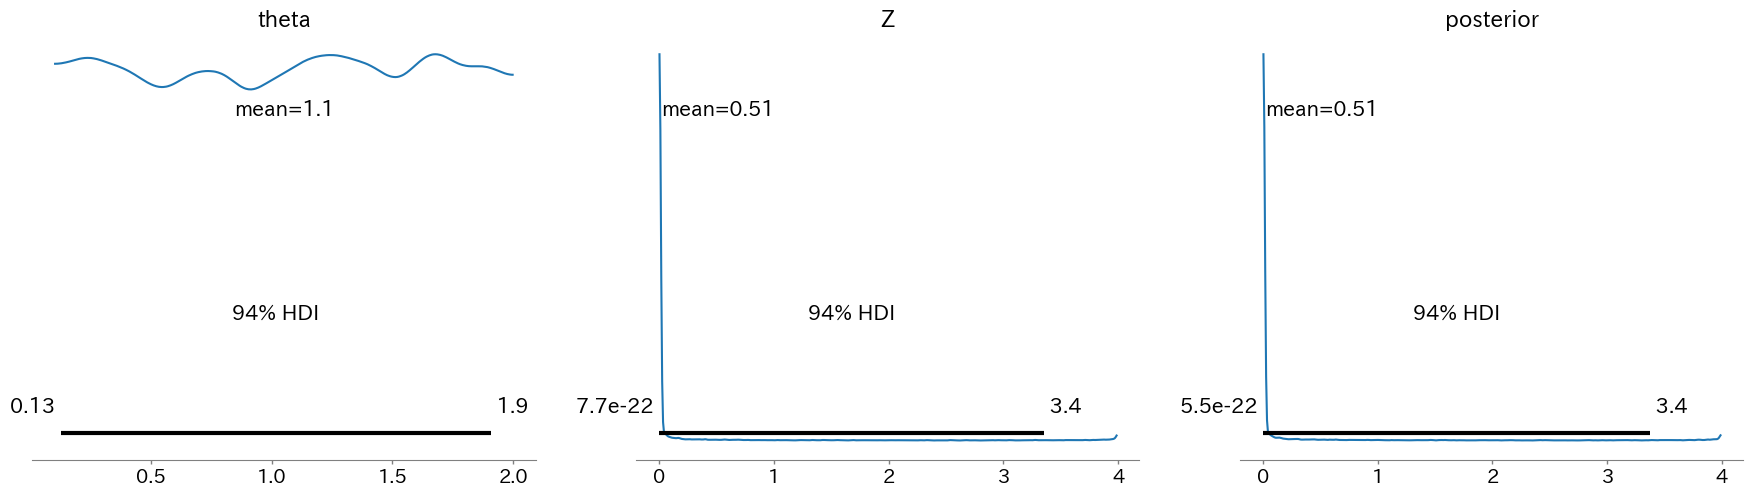

In [335]:
import numpy as np
import pymc3 as pm
import theano.tensor as tt

# 正規分布のパラメータ
mu = 1.0
sigma = 0.1

# 正規分布の確率密度関数
def normal_pdf(x, mu, sigma):
    return tt.exp(-0.5 * (x - mu)**2 / sigma**2) / (sigma * tt.sqrt(2 * np.pi))

# PyMCモデルの定義
with pm.Model() as model:
    # 事前分布の定義
    theta = pm.Uniform('theta', lower=0.1, upper=2.0)
    
    # 正規分布のZ(theta)の定義
    Z = pm.Deterministic('Z', normal_pdf(theta, mu, sigma))
    
    # 事後分布の定義
    posterior = pm.Deterministic('posterior', Z / pm.math.sqrt(theta))
    
    # MCMC設定
    trace = pm.sample(10000, tune=1000, cores=1)

# 結果の表示
pm.summary(trace)

# 事後分布のプロット
pm.plot_posterior(trace)